In [160]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt

# Load the dataset for 2021

In [5]:
players = pd.read_csv('./data/2021/combined.csv').drop(columns='Unnamed: 0')
players.head()

,Player,FPTS,Team,Pos,ROST%,Snaps,Season FPTS,Week
0,Kyler Murray,34.6,ARI,QB,100,69,293.4,1
1,Patrick Mahomes,33.3,KC,QB,100,65,348.0,1
2,Jared Goff,29.9,DET,QB,7,92,184.9,1
3,Jameis Winston,29.6,NO,QB,43,60,120.3,1
4,Tom Brady,29.2,TB,QB,99,65,361.7,1


# Set default parameters for analysis

In [83]:
# Set the league size
league_size = 12

# Set the number of starters per team and the max positions started for a week
position_info = (
    {'QB': {'starters': 1, 'players': 12},
     'RB': {'starters': 2, 'players': 24},
     'WR': {'starters': 3, 'players': 24},
     'TE': {'starters': 1, 'players': 12},
     'Flex': {'starters': 0, 'players': 12},
     'DST': {'starters': 1, 'players': 20},
     'K': {'starters': 1, 'players': 20}}
)

position_players=['QB','RB','WR','TE']

# Determine the average starter and total team production per position for each week

In [7]:
def get_starters(all_players_weekly, sort_col):
    
    '''
    Parameters
    ----------
    all_players_weekly : Dataframe
        Contains all the players for the week. 
    sort_col : String
        Based on the year, the column used to determine the starters may be different.
        Prior to 2021, no Roster Percentage data is available. Use of the highest scoring
        players on the year is used to determine the if they were a starter that week. 
        2021 and beyond has the Roster Percentange data from Yahoo. Sort descending and take
        the top 'n' at each position as the starters.

    Returns
    -------
    starters : Dataframe
        Contains all players that are considered starters for the specified week.
               
    '''
    # Remove players that didn't play (zero snaps) 
    cond1 = all_players_weekly['Snaps'] != 0
    all_players_weekly = all_players_weekly[cond1]

    dfs = []
    # Loop through the position info to determine the number of starters at each position
    for key in position_info:
        if key != 'Flex':
            pos_cutoff = position_info[key]['players']
            df_position = all_players_weekly.groupby('Pos').get_group(key)
            df_position = df_position.sort_values(
                by=sort_col, ascending=False)
            df_position = df_position.head(pos_cutoff)
            df_position.dropna(axis=0, inplace=True)
            dfs.append(df_position)
    starters = pd.concat(dfs, join='outer')

    # Determine flex position players by removing the positional starters
    # The top RB/WR/TE remaining are considering the flex players
    df_flex = all_players_weekly[~all_players_weekly['Player'].isin(
        starters['Player'])]
    df_flex = df_flex[
        (df_flex['Pos'] == 'RB') |
        (df_flex['Pos'] == 'WR') |
        (df_flex['Pos'] == 'TE')
    ]
    df_flex.sort_values(by=sort_col, ascending=False, inplace=True)
    df_flex = df_flex.head(position_info['Flex']['players'])

    starters = pd.concat([starters, df_flex], join='outer')
    return starters

In [8]:
starters = players.groupby('Week', as_index=False).apply(get_starters, sort_col='ROST%')
starters.head()

Player  FPTS Team Pos  ROST%  Snaps  Season FPTS  Week
0 0      Kyler Murray  34.6  ARI  QB    100     69        293.4     1
  7    Russell Wilson  27.1  SEA  QB    100     54        223.7     1
  20       Josh Allen  17.2  BUF  QB    100     85        393.8     1
  19    Lamar Jackson  18.0  BAL  QB    100     68        253.0     1
  1   Patrick Mahomes  33.3   KC  QB    100     65        348.0     1

In [73]:
def get_position_averages(df):
    
    '''
    
    Parameters
    ----------
    df : Dataframe
        Contains all players that are considered starters or replacements for the specified week.

    Returns
    -------
    position_averages : Dictionary
        Contains the mean and standard deviation of fantasy points by position
        for the starters or replacements. Will be used to determine the weekly average team.               
    
    '''
    
    # Groupby position and get the mean fantasy points scored
    mean = (df.groupby('Pos')['FPTS']
            .mean()
            .rename('Mean')
            )
    
    # Groupby position and get the standard deviation of the fantasy points scored
    std = (df.groupby('Pos')['FPTS']
           .std()
           .rename('Std')
           )
    
    # Concatenate the mean and std series into a dataframe and convert to a dictionary
    position_averages = pd.concat([mean, std], axis=1)
    position_averages=position_averages.to_dict('index')
    return position_averages


In [74]:
average_starter = starters.groupby('Week').apply(get_position_averages).to_dict()
average_starter

{1: {'DST': {'Mean': 4.0, 'Std': 4.565315461516092},
  'K': {'Mean': 4.15, 'Std': 4.270769682880421},
  'QB': {'Mean': 22.816666666666666, 'Std': 9.251617385215637},
  'RB': {'Mean': 13.664285714285715, 'Std': 6.811168077650894},
  'TE': {'Mean': 12.891666666666666, 'Std': 8.944115214469063},
  'WR': {'Mean': 17.0375, 'Std': 9.325468076118735}},
 2: {'DST': {'Mean': 5.25, 'Std': 5.655691125341195},
  'K': {'Mean': 5.0, 'Std': 5.647542548941555},
  'QB': {'Mean': 22.633333333333336, 'Std': 8.02069293462324},
  'RB': {'Mean': 14.403571428571428, 'Std': 10.005201689449386},
  'TE': {'Mean': 12.316666666666668, 'Std': 6.695158811794647},
  'WR': {'Mean': 15.475, 'Std': 8.173047759399143}},
 3: {'DST': {'Mean': 4.95, 'Std': 5.7351639264416745},
  'K': {'Mean': 5.0, 'Std': 4.984185516527037},
  'QB': {'Mean': 24.383333333333336, 'Std': 6.05487532088937},
  'RB': {'Mean': 14.728571428571428, 'Std': 7.8367064672583115},
  'TE': {'Mean': 9.975, 'Std': 5.674844811654644},
  'WR': {'Mean': 14.165

In [49]:
def get_average_team(df):

    # Calculate the mean and standard deviation for an entire team
    # of average starters. Consists of multiplying the mean and std. dev
    # by the number of starters at the position.
    
    #Convert the weekly data to a dictionary for ease of looping
    position_dict = df.set_index('Pos').to_dict()
    
    mean=0
    variance=0
    for position in position_info:
        if position != 'Flex':
            mean += position_dict['Mean'][position]*position_info[position]['starters']
            
            # Square standard deviation to convert to variance then mutliply by starters
            # for that position
            variance += (position_dict['Std'][position]**2)*position_info[position]['starters']
            
            # Take the square root because this value is a variance 
            std=np.sqrt(variance)
            
        average_team={
            'Mean':round(mean,2),
            'Std':round(std,2)
            }
    return average_team

In [50]:
average_team = average_starter.groupby('Week').apply(get_average_team).to_dict()
average_team

{1: {'Mean': 122.3, 'Std': 23.63},
 2: {'Mean': 120.43, 'Std': 23.95},
 3: {'Mean': 116.26, 'Std': 21.94},
 4: {'Mean': 114.08, 'Std': 23.07},
 5: {'Mean': 133.84, 'Std': 27.77},
 6: {'Mean': 117.96, 'Std': 21.97},
 7: {'Mean': 113.79, 'Std': 22.39},
 8: {'Mean': 107.51, 'Std': 21.37},
 9: {'Mean': 99.53, 'Std': 20.37},
 10: {'Mean': 104.28, 'Std': 21.51},
 11: {'Mean': 115.92, 'Std': 26.5},
 12: {'Mean': 107.13, 'Std': 22.38},
 13: {'Mean': 114.62, 'Std': 23.87},
 14: {'Mean': 117.69, 'Std': 24.5},
 15: {'Mean': 98.42, 'Std': 23.58},
 16: {'Mean': 113.87, 'Std': 24.56},
 17: {'Mean': 114.29, 'Std': 24.82},
 18: {'Mean': 112.8, 'Std': 22.08}}

Text(0, 0.5, 'Points Scored')

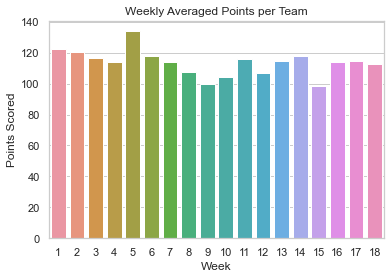

In [97]:
g = sns.barplot(x='index', y='Mean', data=pd.DataFrame.from_dict(average_team, orient='index').reset_index())
g.set_title('Weekly Averaged Points per Team')
g.set_xlabel('Week')
g.set_ylabel('Points Scored')

# Calculate the average replacement player per position

In [67]:
def get_replacements(all_players_weekly, starters, sort_col):
    '''
    Returns a nested dictionary with the four positions (QB, RB, etc.) that provide
    the FGW for each one and the replacement player average points. 
    This value will be used to subtract from the actual players FGW to determine 
    the player's Wins Above Replacement (WAR).
    '''
    
    starters = starters[starters.Week == all_players_weekly.Week.max()]
    positions=['QB','RB','WR','TE']
    replacements=all_players_weekly[~all_players_weekly['Player'].isin(starters['Player'])]
    
    # Remove players that didn't play (zero snaps)
    cond1 = replacements['Snaps'] != 0
    replacements = replacements[cond1]

    dfs = []
    # Loop through the position info to determine the number of replacements at each position
    for position in positions:
        pos_cutoff = position_info[position]['players']
        df = replacements.groupby('Pos').get_group(position)
        df = df.sort_values(
            by=sort_col, ascending=False)
        df = df.head(pos_cutoff)
        df.dropna(axis=0, inplace=True)
        dfs.append(df)
    replacements = pd.concat(dfs, join='outer')
    replacements.drop(columns='Week', inplace=True)
    return replacements

In [70]:
replacements = players.groupby('Week').apply(get_replacements, starters=starters, sort_col='ROST%').reset_index().drop(columns='level_1')
replacements.head()

,Week,Player,FPTS,Team,Pos,ROST%,Snaps,Season FPTS
0,1,Joe Burrow,18.6,CIN,QB,85,69,328.1
1,1,Trevor Lawrence,22.1,JAC,QB,79,74,197.4
2,1,Baker Mayfield,13.6,CLE,QB,74,59,193.8
3,1,Matt Ryan,7.4,ATL,QB,73,70,223.0
4,1,Kirk Cousins,22.0,MIN,QB,66,83,285.4


In [75]:
average_replacement = replacements.groupby('Week').apply(get_position_averages).to_dict()
average_replacement

{1: {'QB': {'Mean': 14.125, 'Std': 8.397415728013645},
  'RB': {'Mean': 8.424999999999999, 'Std': 6.921752102893677},
  'TE': {'Mean': 8.616666666666667, 'Std': 6.891342834354279},
  'WR': {'Mean': 12.625, 'Std': 7.532206212975228}},
 2: {'QB': {'Mean': 14.700000000000001, 'Std': 8.905361000288227},
  'RB': {'Mean': 8.595833333333333, 'Std': 6.239459227310918},
  'TE': {'Mean': 4.741666666666666, 'Std': 3.049130526838261},
  'WR': {'Mean': 11.929166666666667, 'Std': 7.774734955172967}},
 3: {'QB': {'Mean': 14.575000000000001, 'Std': 6.150110863745761},
  'RB': {'Mean': 9.091666666666667, 'Std': 7.003782621876036},
  'TE': {'Mean': 8.549999999999999, 'Std': 5.837418482981544},
  'WR': {'Mean': 10.237499999999999, 'Std': 5.436256104598329}},
 4: {'QB': {'Mean': 18.183333333333334, 'Std': 8.472504549029958},
  'RB': {'Mean': 8.754166666666666, 'Std': 8.380981532569761},
  'TE': {'Mean': 9.616666666666667, 'Std': 6.8492645037569},
  'WR': {'Mean': 11.174999999999999, 'Std': 6.0645262189943

# Calculate the added win probability compared to a replacement player

In [92]:
def calculate_wins_above_replacement(row):
    points = row.FPTS
    position = row.Pos
    snaps = row.Snaps
    week = row.Week
    
    if (snaps != 0) & (position in position_players):
        # Get the parameters of the average player for that position/week
        average_starter_points = average_starter[week][position]['Mean']
        average_replacement_points = average_replacement[week][position]['Mean']
        
        # Get the average team parameters for the week
        average_team_std = average_team[week]['Std']
        
        # Combine the two distributions (our team with the actual player or a replacement player versus an average opponents team)
        mu_player = (points - average_starter_points)
        mu_replacement = (average_starter_points - average_replacement_points)
        
        # Compute the winning percentage for the actual player and the replacement player (i.e. mu > 0)
        # Combine the two distributions standard deviation (convert to variance)
        sigma=np.sqrt(2*(average_team_std**2))
        
        win_player = (1-norm(mu_player,sigma).cdf(0))
        win_replacement = (1-norm(mu_replacement,sigma).cdf(0))

        return win_player - win_replacement
    else:
        # If the player didn't play, assume they're replaced by a replacement player
        return None

In [93]:
players['WAR'] = players.apply(lambda row: calculate_wins_above_replacement(row), axis = 1)
players.head()

,Player,FPTS,Team,Pos,ROST%,Snaps,Season FPTS,Week,WAR
0,Kyler Murray,34.6,ARI,QB,100,69,293.4,1,0.240411
1,Patrick Mahomes,33.3,KC,QB,100,65,348.0,1,0.225730
2,Jared Goff,29.9,DET,QB,7,92,184.9,1,0.186535
3,Jameis Winston,29.6,NO,QB,43,60,120.3,1,0.183030
4,Tom Brady,29.2,TB,QB,99,65,361.7,1,0.178346


In [94]:
season_war = players.groupby(['Player', 'Pos', 'Team'], as_index=False)['WAR'].sum()
season_war.dropna(inplace=True)
season_war.sort_values(by='WAR', ascending=False, inplace=True)
season_war

,Player,Pos,Team,WAR
73,Cooper Kupp,WR,LAR,3.264378
202,Jonathan Taylor,RB,IND,2.749960
23,Austin Ekeler,RB,LAC,2.507334
114,Deebo Samuel,WR,SF,2.164775
206,Josh Allen,QB,BUF,2.119554
...,...,...,...,...
368,Tyler Johnson,WR,TB,-0.925971
121,Devin Duvernay,WR,BAL,-0.926156
337,Tajae Sharpe,WR,ATL,-0.994942
172,Jalen Reagor,WR,PHI,-1.034293


Text(0, 0.5, 'Player')

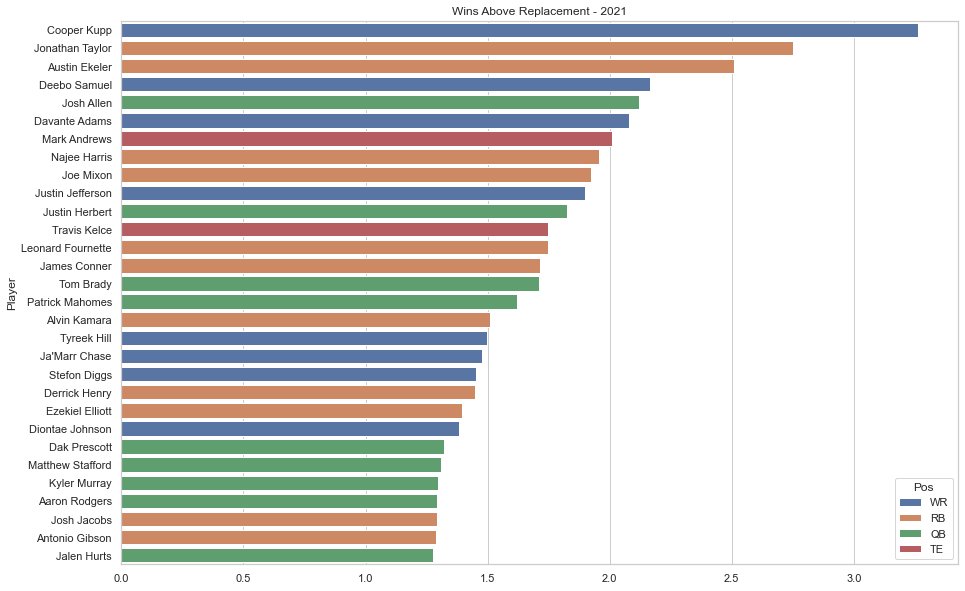

In [111]:
fig = plt.figure(figsize=(15,10))

g = sns.barplot(x='WAR', y='Player', hue = 'Pos', data=season_war.head(30), dodge=False)
g.set_title('Wins Above Replacement - 2021')
g.set_xlabel(None)
g.set_ylabel('Player')

In [110]:
weekly_war = players[players.Snaps != 0].groupby(['Player', 'Pos', 'Team'], as_index=False)['WAR'].mean()
weekly_war.sort_values(by='WAR', ascending=False, inplace=True)
weekly_war.head()

,Player,Pos,Team,WAR
73,Cooper Kupp,WR,LAR,0.192022
118,Derrick Henry,RB,TEN,0.180794
196,Jonathan Taylor,RB,IND,0.161762
23,Austin Ekeler,RB,LAC,0.156708
114,Deebo Samuel,WR,SF,0.135298


Text(0, 0.5, 'Player')

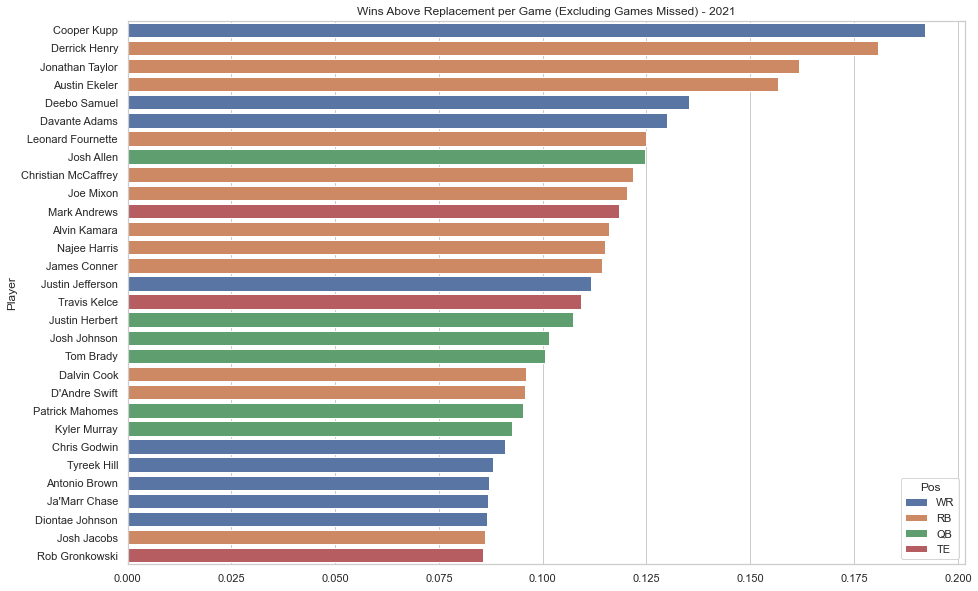

In [179]:
fig = plt.figure(figsize=(15,10))

g = sns.barplot(x='WAR', y='Player', hue = 'Pos', data=weekly_war.head(30), dodge=False)
g.set_title('Wins Above Replacement per Game (Excluding Games Missed) - 2021')
g.set_xlabel(None)
g.set_ylabel('Player')

# Single player in detail
* Explore a single players WAR in detail
* Visualizes the methodology

In [114]:
derrick_henry = players[players.Player == 'Derrick Henry']
derrick_henry.head()

,Player,FPTS,Team,Pos,ROST%,Snaps,Season FPTS,Week,WAR
71,Derrick Henry,10.7,TEN,RB,100,40,193.3,1,0.026950
394,Derrick Henry,47.7,TEN,RB,100,67,193.3,2,0.405282
756,Derrick Henry,19.4,TEN,RB,100,49,193.3,3,0.131917
1101,Derrick Henry,25.7,TEN,RB,100,59,193.3,4,0.204200
1453,Derrick Henry,31.0,TEN,RB,100,49,193.3,5,0.206970


### Plot the team scoring distribution for week 2

In [206]:
def plot_team_distribution(week, position, type:str):
    
    derrick_henry_points = derrick_henry[derrick_henry.Week == week]['FPTS']
    
    # Get the parameters of the average player for that position/week
    average_starter_points = average_starter[week][position]['Mean']
    average_replacement_points = average_replacement[week][position]['Mean']

    # Get the average team parameters for the week
    average_team_points = average_team[week]['Mean']
    average_team_std = average_team[week]['Std']

    # Compute how much the average team score changes with Derrick Henry or a replacement level player
    mu_player = derrick_henry_points - average_starter_points
    mu_replacement = average_replacement_points - average_starter_points

    our_team = np.random.normal(average_team_points + mu_player, average_team_std, size = 100000)
    our_team_replacement = np.random.normal(average_team_points + mu_replacement, average_team_std, size = 100000)
    opponent = np.random.normal(average_team_points, average_team_std, size = 100000)
    
    if type == 'Replacement':
        data = pd.DataFrame.from_dict({'Our Team w/ Replacement': our_team_replacement, 'Opponent': opponent})
    else:
        data = pd.DataFrame.from_dict({'Our Team w/ Derrick Henry': our_team, 'Opponent': opponent})

    fig = plt.figure()
    sns.set_style("whitegrid", {'axes.grid' : False})
    g = sns.displot(data, kind='kde', height=10, aspect=1, fill=True, palette=sns.color_palette('bright')[:2])


<Figure size 432x288 with 0 Axes>

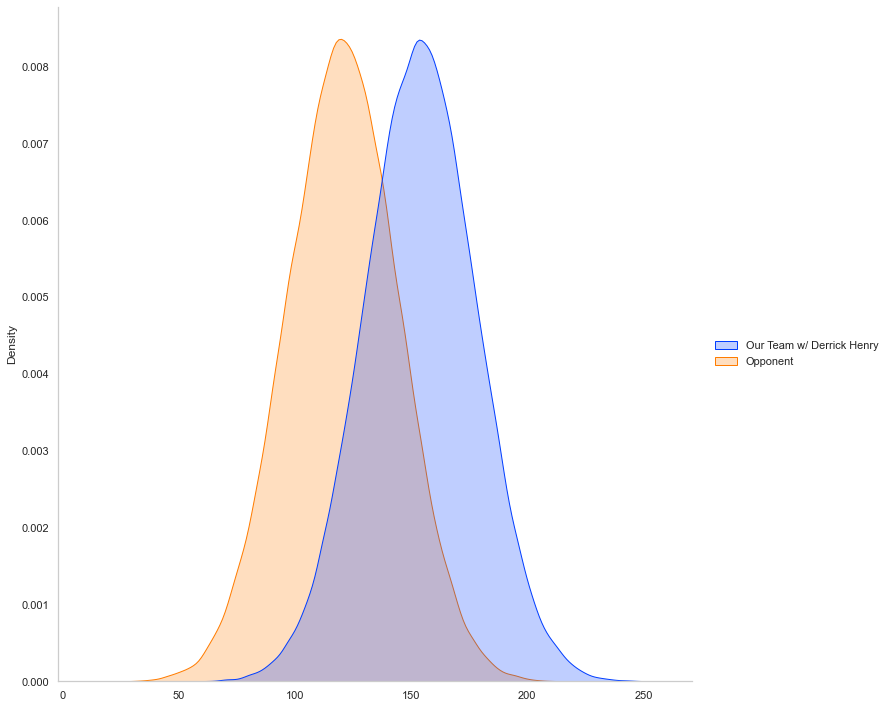

In [210]:
plot_team_distribution(2, 'RB', type='Player')

<Figure size 432x288 with 0 Axes>

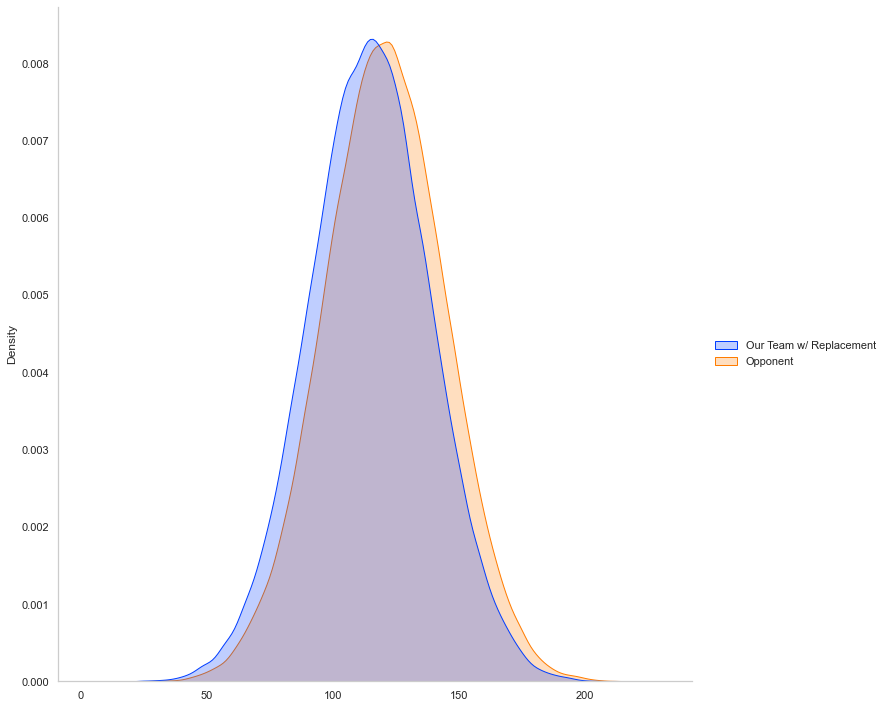

In [209]:
plot_team_distribution(2, 'RB', type='Replacement')

In [312]:
def plot_combined_distribution(week, position):
    
    derrick_henry_points = derrick_henry[derrick_henry.Week == week]['FPTS']
    
    # Get the parameters of the average player for that position/week
    average_starter_points = average_starter[week][position]['Mean']
    average_replacement_points = average_replacement[week][position]['Mean']

    # Get the average team parameters for the week
    average_team_points = average_team[week]['Mean']
    average_team_std = average_team[week]['Std']

    # Compute how much the average team score changes with Derrick Henry or a replacement level player
    mu_player = derrick_henry_points - average_starter_points
    mu_replacement = average_replacement_points - average_starter_points
    
    # Double the variance because we're combining two normal distributions
    sigma = np.sqrt(2*(average_team_std**2))

    no_replacement = np.random.normal(mu_player, sigma, size = 100000)
    replacement = np.random.normal(mu_replacement, sigma, size = 100000)
    
    # Get the winning percentage
    win_no_replacement = float((1-norm(mu_player,sigma).cdf(0)))
    win_replacement = (1-norm(mu_replacement,sigma).cdf(0))
    
    # Plot the combined distributions
    fig, axes =plt.subplots(1,2,figsize=(15,10), sharey=True)
    sns.set_style("whitegrid", {'axes.grid' : False})
    
    count = 0
    for ax in axes:
        if count == 0:
            sns.kdeplot(no_replacement, ax=ax, shade=False)
            ax.title.set_text(f'Our Team w/ Derrick Henry vs Opponent (Win % = {round(100*win_no_replacement,1)})')
        else: 
            sns.kdeplot(replacement, ax=ax, shade=False)
            ax.title.set_text(f'Our Team w/ replacement vs Opponent (Win % = {round(100*win_replacement,1)})')
        kdeline = ax.get_lines()[-1]
        x = kdeline.get_data()[0]
        y = kdeline.get_data()[1]   
        mask = x > 0
        x, y = x[mask], y[mask]
        ax.fill_between(x, y1=y, alpha=0.5, facecolor='red')
        count +=1

0.8372094366370398


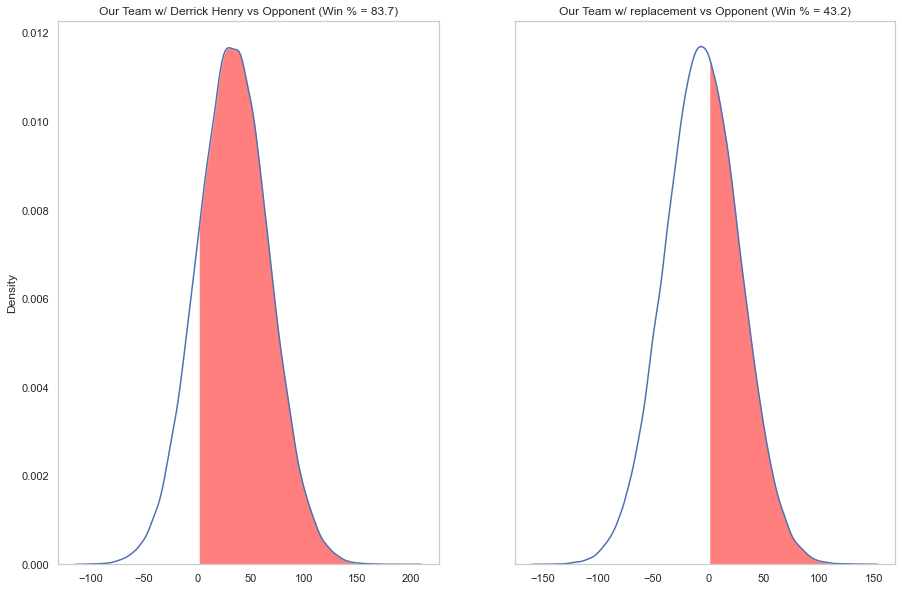

In [313]:
plot_combined_distribution(2, 'RB')